# QC and filtering
<hr style="border:2px solid black"> </hr>

**Quality control**

"We must ensure that all cellular barcode data correspond to viable cells.

Cell QC is commonly performed based on three QC covariates: the number of counts per barcode (count depth), the number of genes per barcode, and the fraction of counts from mitochondrial genes per barcode.

The distributions of these QC covariates are examined for outlier peaks that are filtered out by thresholding.

These outlier barcodes can correspond to dying cells, cells whose membranes are broken, or doublets".

Samples with a low count depth, few detected genes, and a high fraction of mitochondrial counts are indicative of cells whose cytoplasmic mRNA has leaked out through a broken membrane.

In contrast, cells with unexpectedly high counts and a large number of detected genes may represent doublets.

**DOI: 10.15252/msb.20188746**

<hr style="border:2px solid black"> </hr>
<h1><center>⬐ Fill in input data here ⬎</center></h1>

In [1]:
# Set the species of the data
species = "mouse"

# Set the column in adata.obs containing the biological condition to evaluate
condition_column = "condition"

# Set the column in adata.var containing gene names
gene_column = "gene"

<hr style="border:2px solid black"> </hr>

## Setup

In [12]:
#####################IMPORTING PACKAGES#############################
import sctoolbox.utilities as utils
import sctoolbox.marker_genes as marker_genes
import sctoolbox.analyser as analyser
import sctoolbox.qc_filter as qc
import sctoolbox.plotting as pl

## Load anndata
Uses anndata object written by the previous notebook.

In [3]:
adata = utils.load_anndata(is_from_previous_note=True, which_notebook=1, data_to_evaluate=condition_column)
display(adata)

AnnData object with n_obs × n_vars = 20192 × 55359
    obs: 'sample', 'condition', 'batch'
    var: 'gene', 'type'
    uns: 'color_set', 'infoprocess'
    layers: 'ambiguous', 'spliced', 'unspliced'

## Label genes
Mark genes on their general association. E.g. mitochondrial.

In [4]:
marker_genes.label_genes(adata, gene_column=gene_column, species=species)

display(adata.uns["infoprocess"]["genes_labeled"])

['is_ribo', 'is_mito', 'is_gender']

## Calculate QC metrics
Create quality control metrics to filter the data on.

In [5]:
# If control_var=True, include gene labels from in qc computation
# TODO can't be disabled at the moment
adata = analyser.qcmetric_calculator(adata, control_var=True)

## Create filter thresholds
Dynamically create & show thresholds based on the distribution shape of the data.

* total_counts:  
    * Low and high count depth indicates cells with low integrity and doublets, respectively (DOI: 10.15252/msb.20188746).

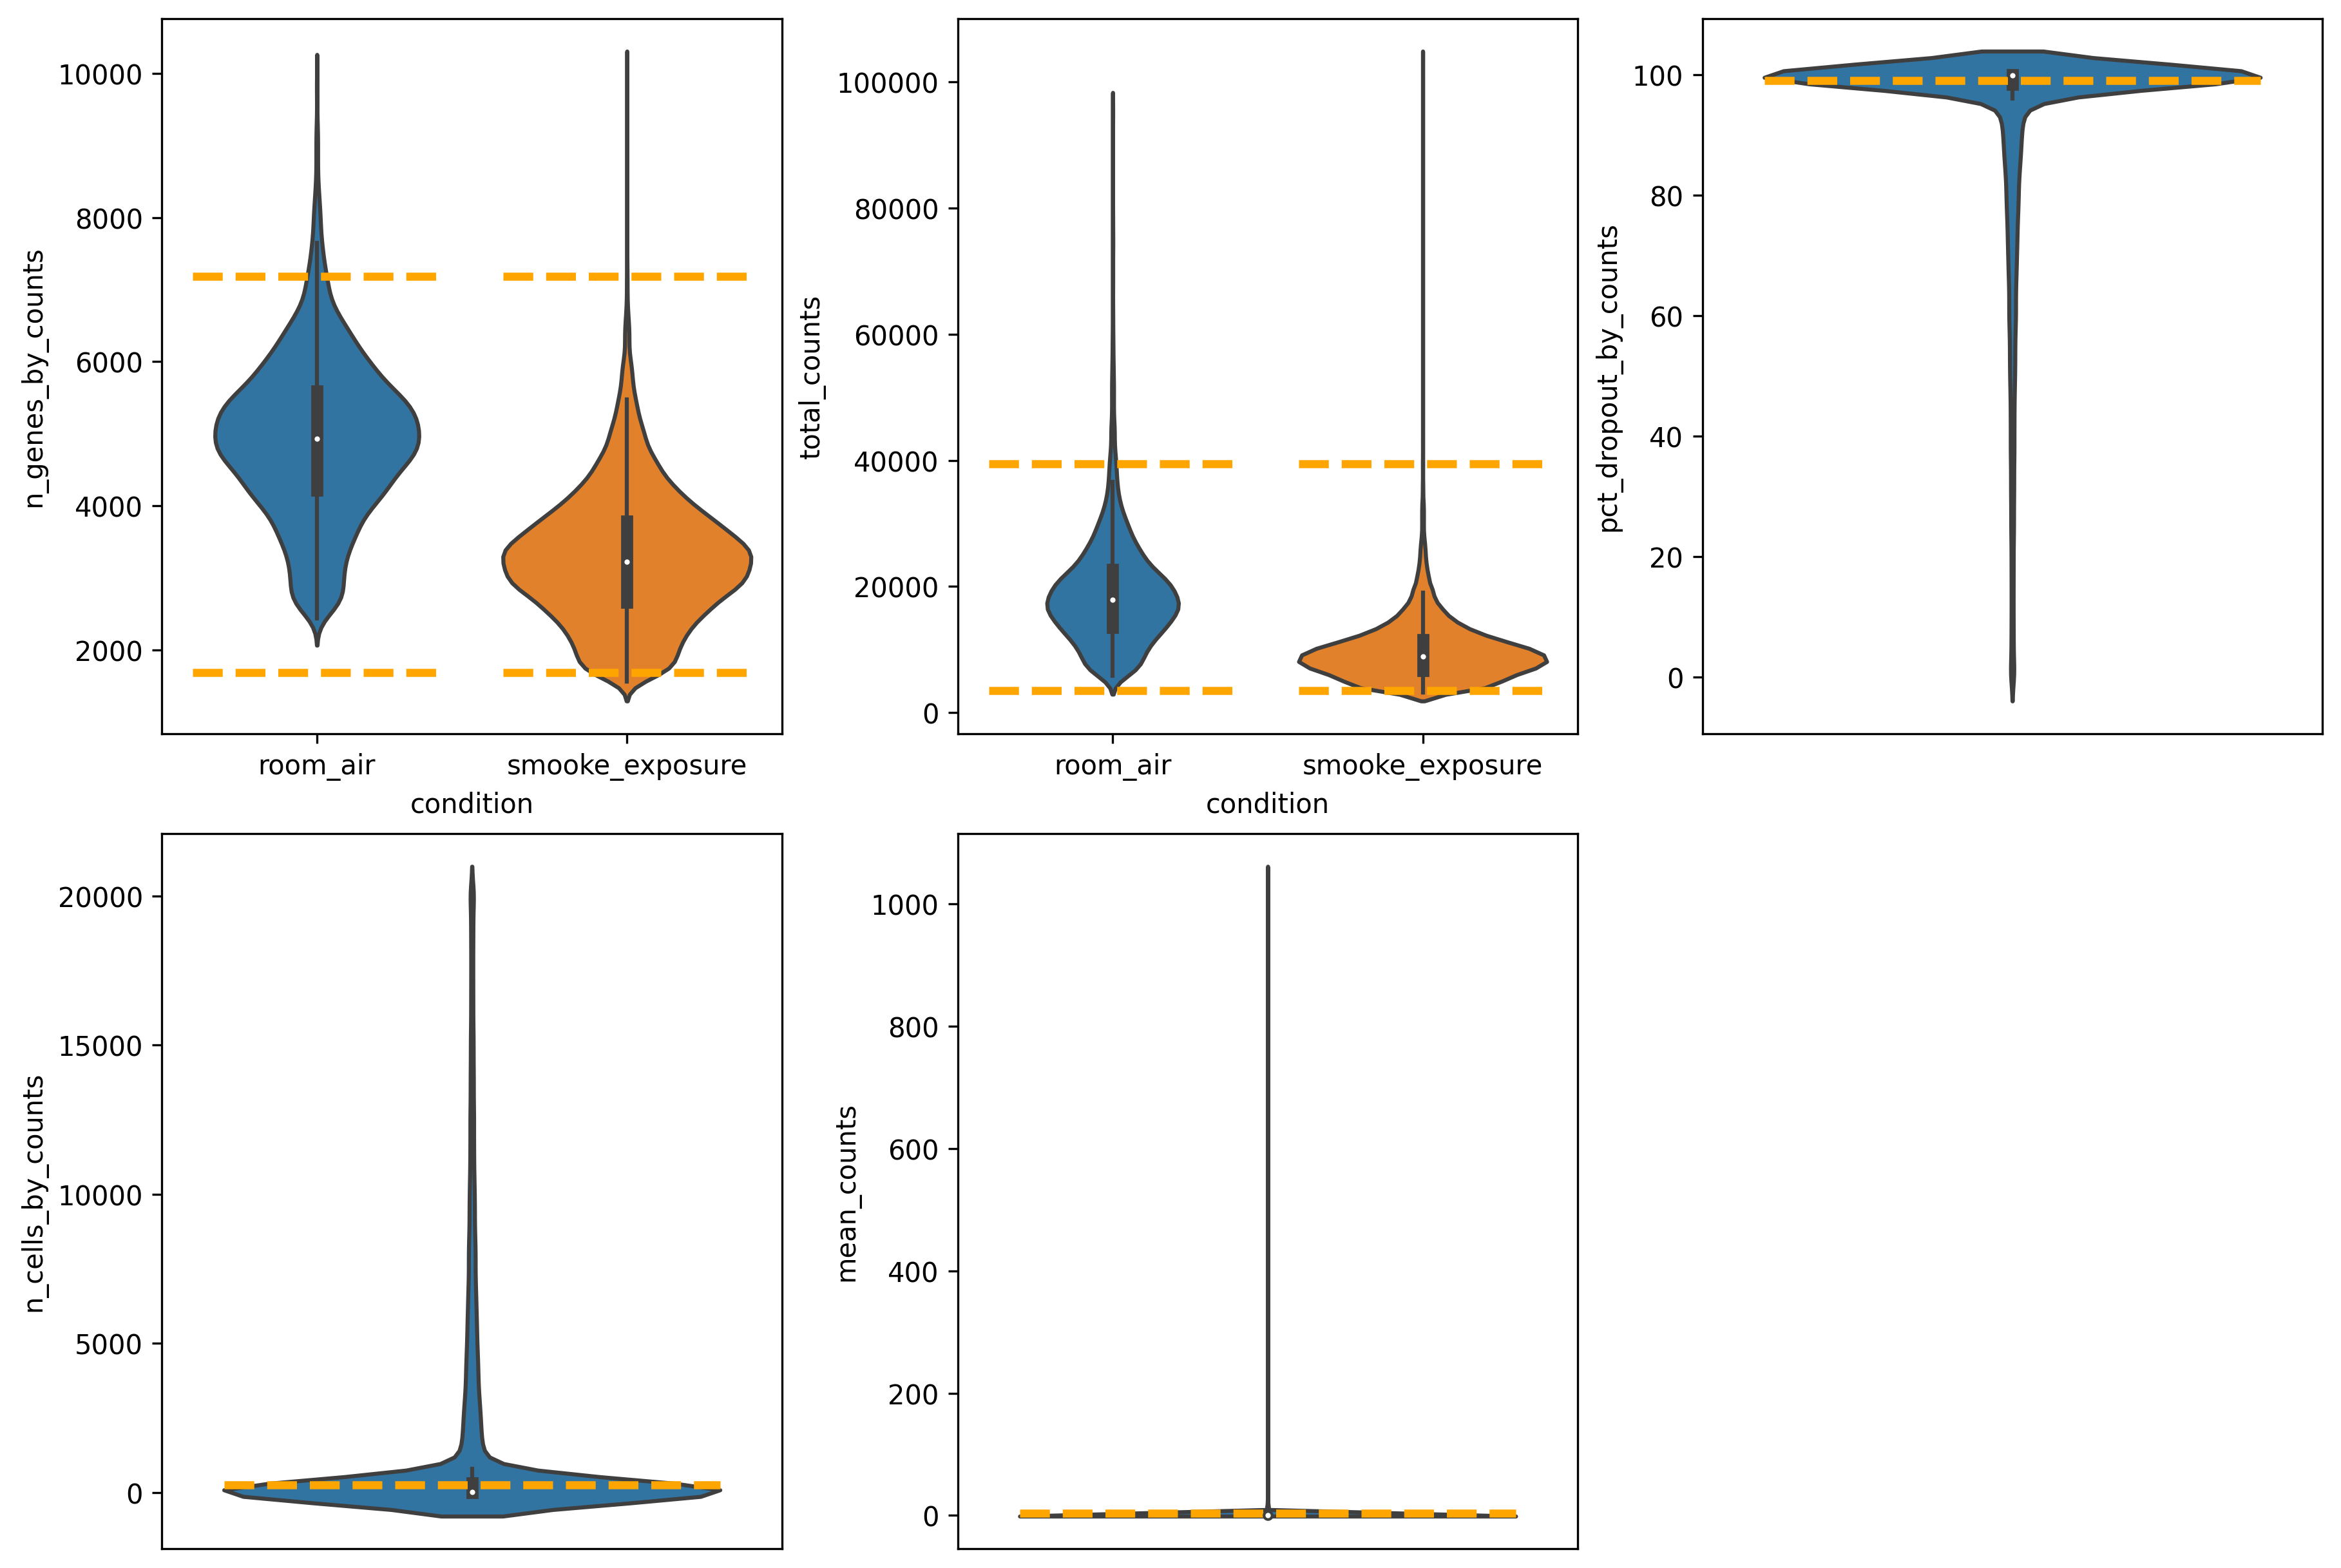

In [6]:
# generate thresholds for the given qc metrics
thresholds = qc.find_thresholds(adata, 
                                interval=0.95,
                                var=["pct_dropout_by_counts", "n_cells_by_counts", "mean_counts"], 
                                obs=["n_genes_by_counts", "total_counts"], 
                                var_color_by=None, 
                                obs_color_by=condition_column,
                                show_thresholds=True,
                                output=None
                               )                              

In [7]:
thresholds

,threshold,color_by
index,,
n_genes_by_counts,"(1683.8145, 7180.1855)",condition
total_counts,"(3453.8145, 39492.27499999998)",condition
pct_dropout_by_counts,"(99.09584086799276, None)",None
n_cells_by_counts,"(255.59493670886073, None)",None
mean_counts,"(None, 3.325830810069979)",None


## Customize thresholds
Add, update or remove thresholds as needed

In [8]:
qc.refine_thresholds(thresholds, inplace=True)


              1. Add new threshold row
              2. Edit threshold row
              3. Remove threshold row
              4. Show table
              5. Quit
              
What do you want to do?: 4


,index,threshold,color_by
0,n_genes_by_counts,"(1683.8145, 7180.1855)",condition
1,total_counts,"(3453.8145, 39492.27499999998)",condition



              1. Add new threshold row
              2. Edit threshold row
              3. Remove threshold row
              4. Show table
              5. Quit
              
What do you want to do?: 5
Are you sure you want to quit? [y/N]: y


In [9]:
thresholds

,threshold,color_by
index,,
n_genes_by_counts,"(1683.8145, 7180.1855)",condition
total_counts,"(3453.8145, 39492.27499999998)",condition


## Apply thresholds
Filter the anndata object based on the thresholds in the threshold table.

In [10]:
qc.anndata_filter(adata, thresholds=thresholds, inplace=True)

## Filter marked genes
Remove genes that are labeled as e.g. mitochondrial genes.

In [12]:
# TODO test code
#remove mitochondrial
#adata4 = qc.filter_genes(adata3, "is_mitochondrial")
    
#remove cell cycle
#adata4 = qc.filter_genes(adata3, "is_cell_cycle")

#Remove gender genes
#adata4 = qc.filter_genes(adata3, "is_gender_genes")

#Remove custom genes from list
#adata4 = qc.filter_genes(adata3, "is_custom")

## Show data
Inspect data after it has been filtered

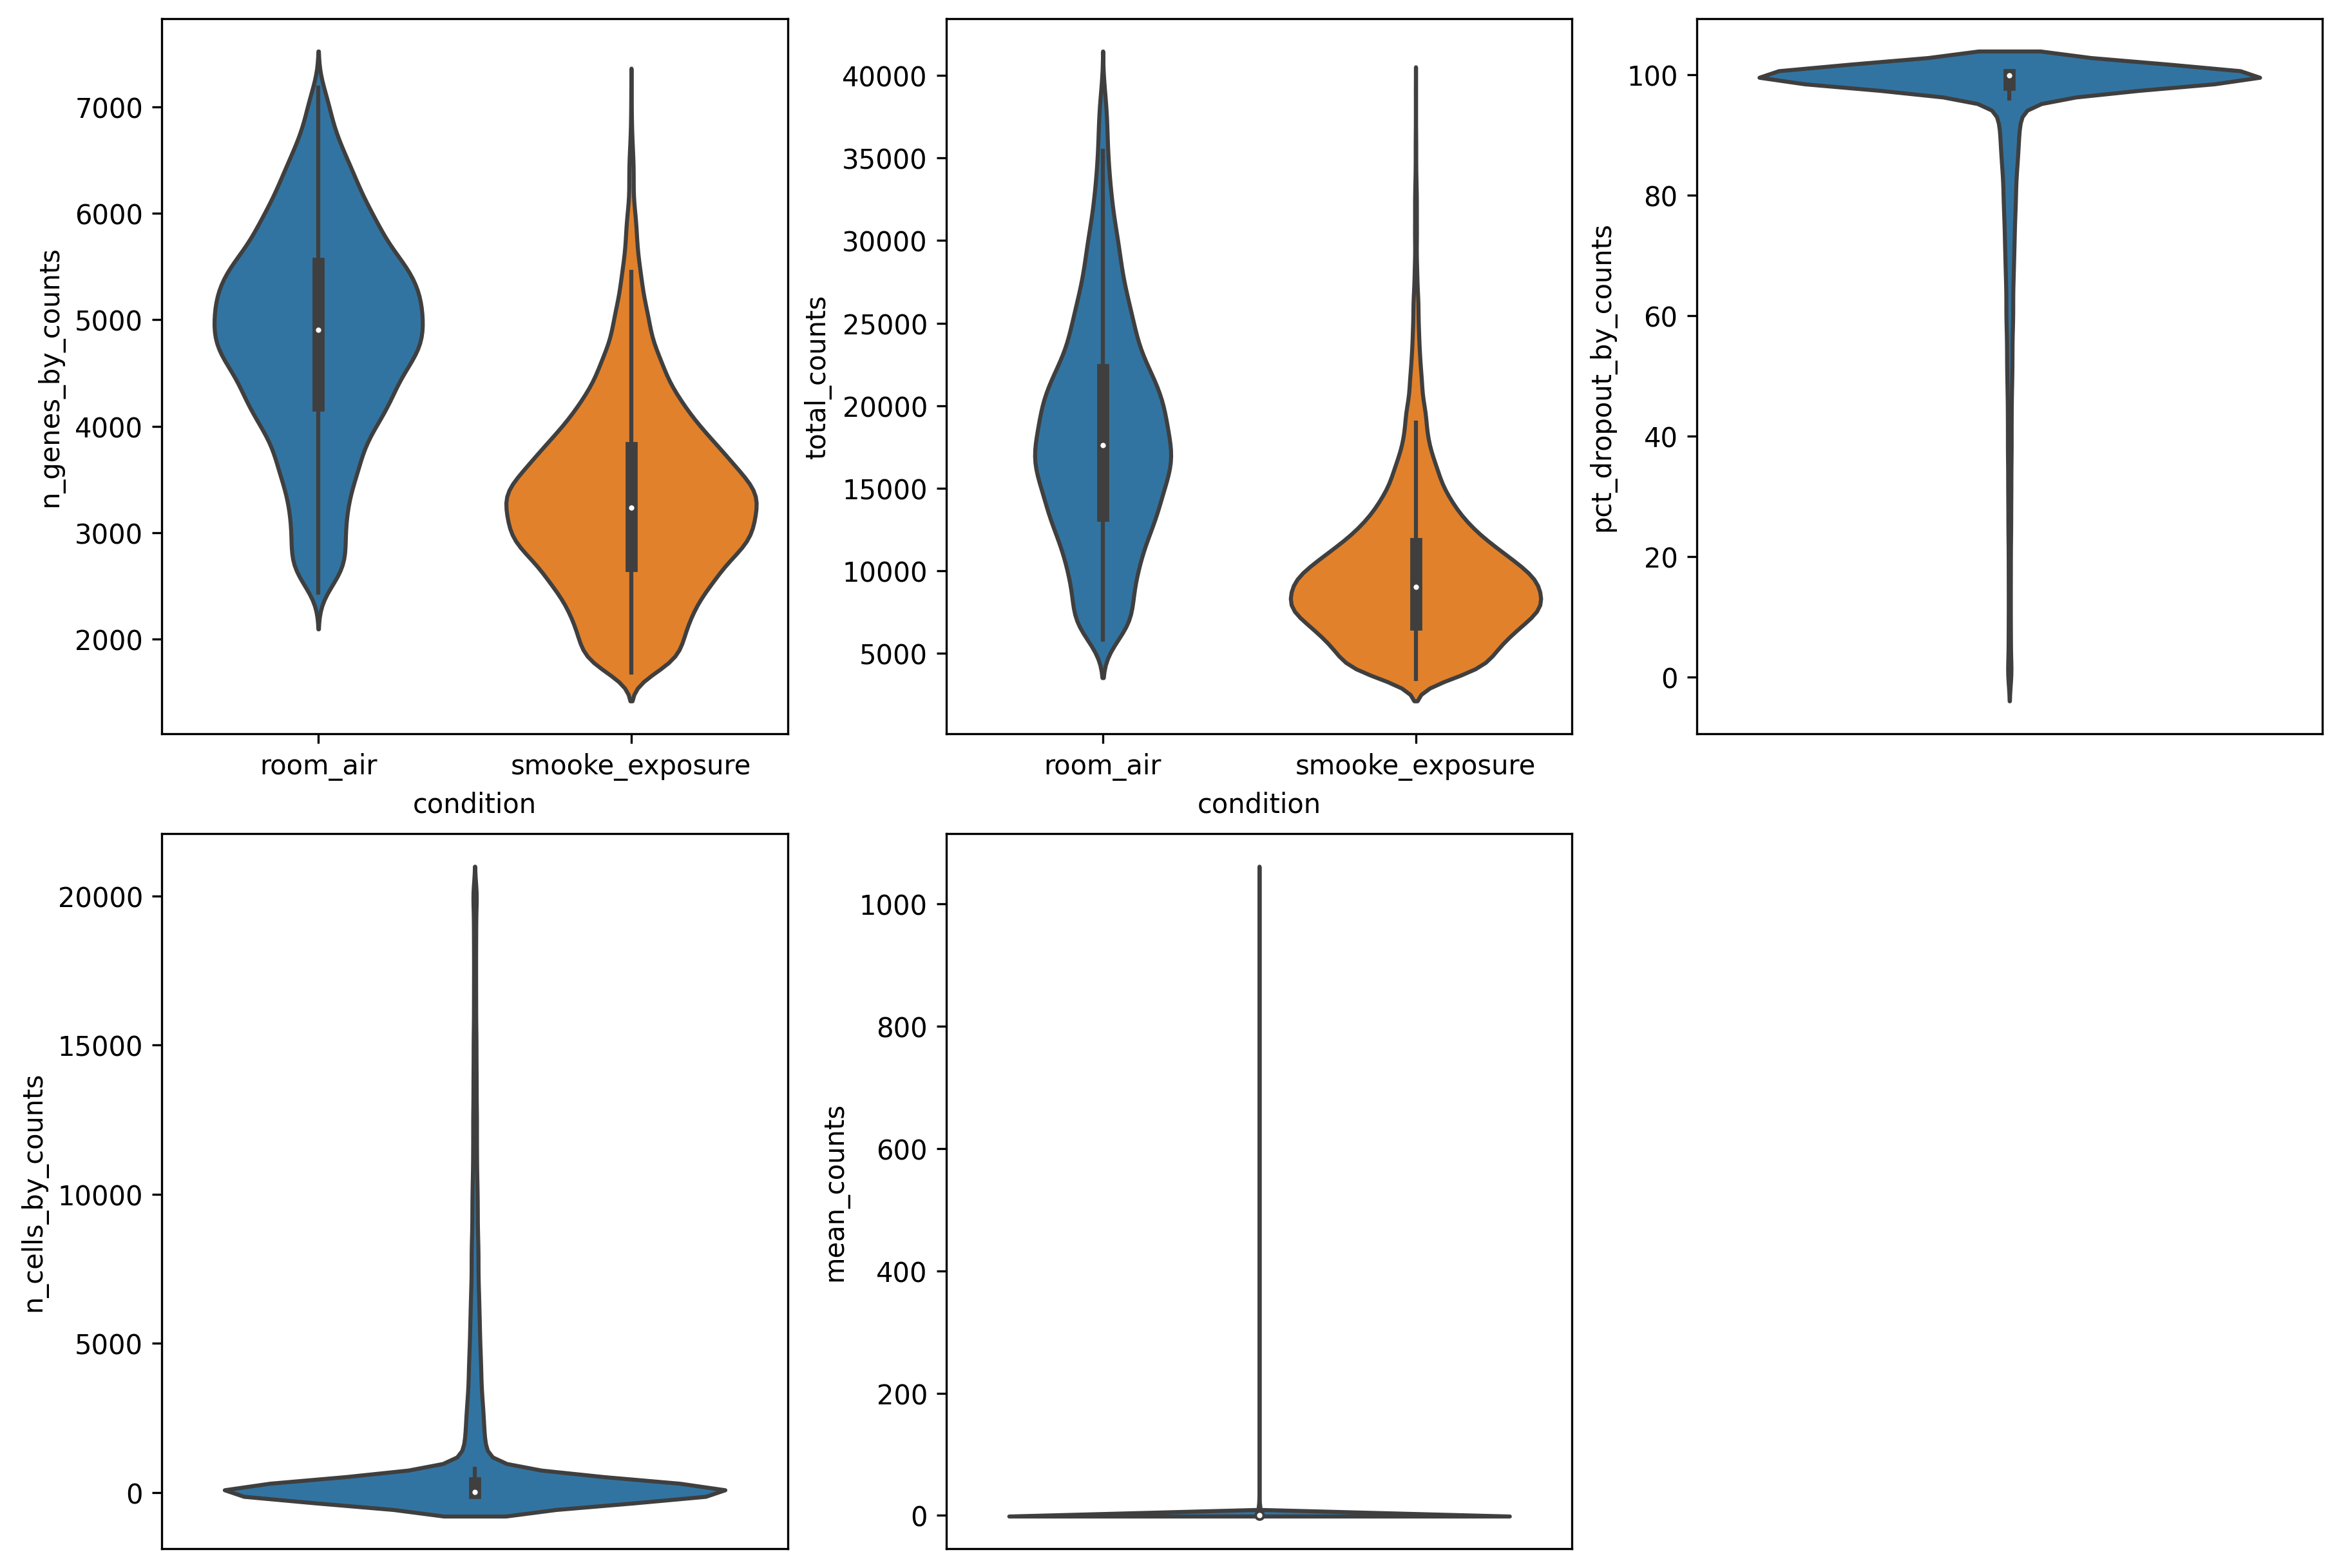

In [11]:
_ = qc.find_thresholds(adata, 
                       interval=0.95,
                       var=["pct_dropout_by_counts", "n_cells_by_counts", "mean_counts"], 
                       obs=["n_genes_by_counts", "total_counts"], 
                       var_color_by=None, 
                       obs_color_by=condition_column,
                       show_thresholds=False,
                       output=None
                      )      

Show violins with threshold

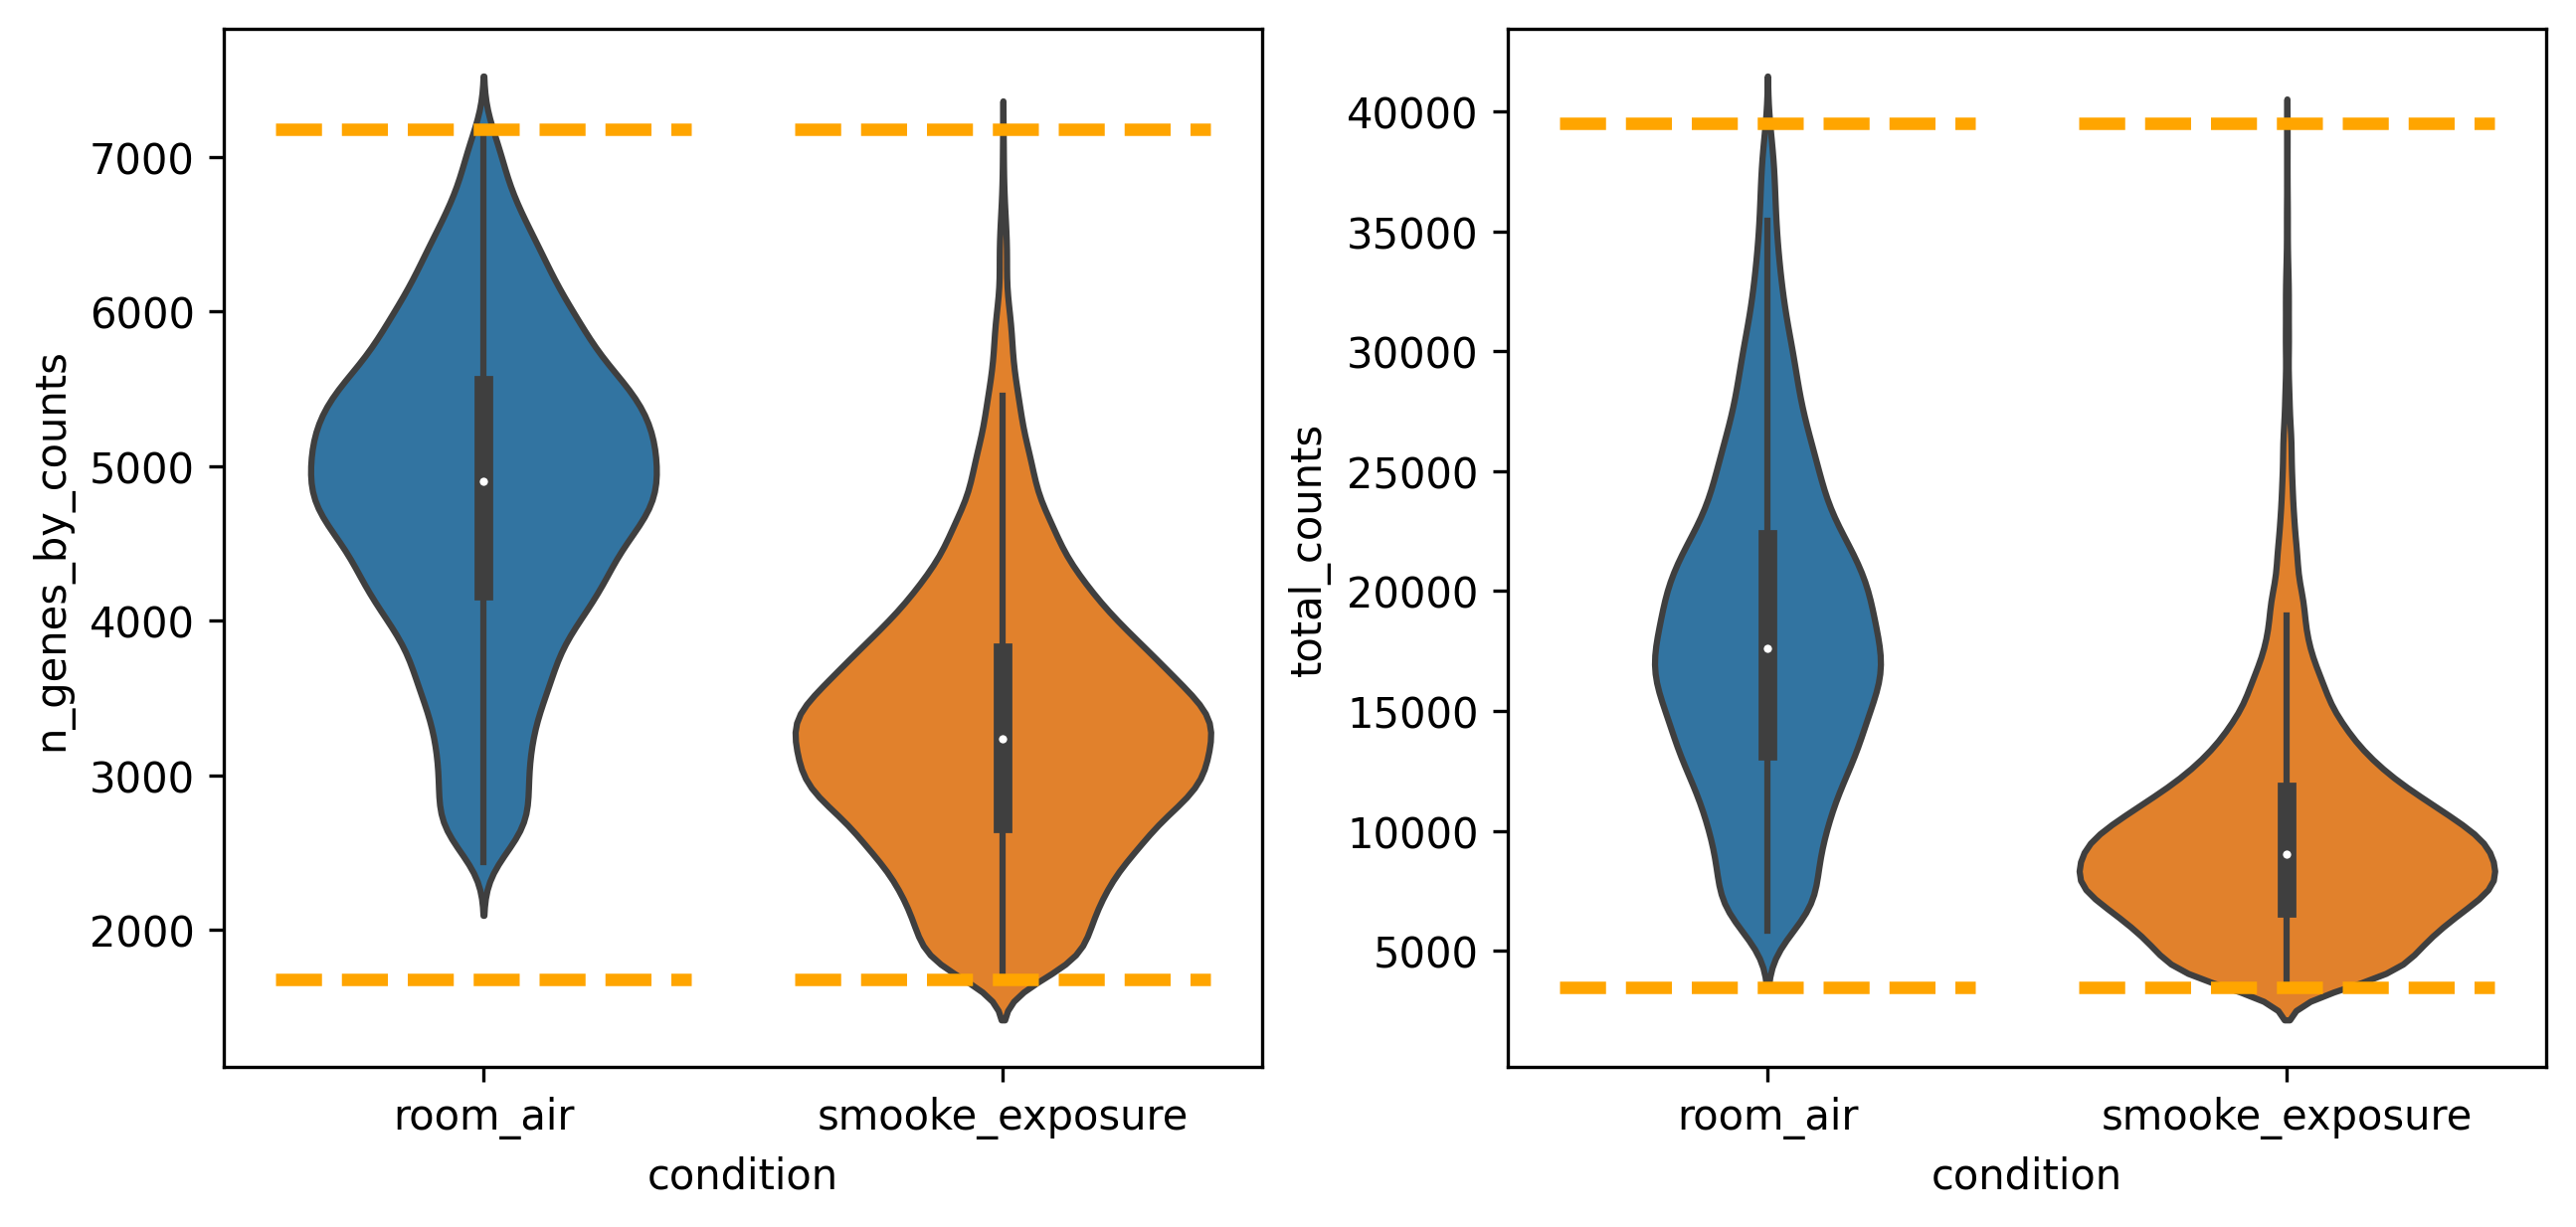

In [13]:
pl.qc_violins(adata,
              thresholds=thresholds,
              colors=None,
              filename=None,
              ncols=3,
              figsize=None,
              dpi=300
             )

## Save adata
Store the final results

In [20]:
utils.saving_anndata(adata, current_notebook=2) #hack to get to notebook 3

Your new anndata object is saved here: pipeline_output/results/Test1/anndata_2_Test1.h5ad
